In [1]:
#  Import the packages
from math import floor, ceil

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import queue
import glob
import os
import json
from PIL import Image, ImageDraw
from shapely import wkt, geometry
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.python.keras.utils.data_utils import Sequence
from sklearn.model_selection import train_test_split

## Setting the Data Path

In [2]:
PATH_TO_DATASET = "D:\\Study\\X\\binet_AI\\nuit_de_IA_20190928\\train\\train\\"

In [9]:
SIZE_CUTS = 128       # size of the sub images extracted (in pixels)
SIZE_BUILDING_SEARCH = 8  # size of the granularity for building detection (should be smaller than SIZE_CUTS)

points_grid = [[geometry.Point(SIZE_BUILDING_SEARCH*i+SIZE_BUILDING_SEARCH//2, \
                SIZE_BUILDING_SEARCH*j+SIZE_BUILDING_SEARCH//2) \
                for j in range((2**10)//SIZE_BUILDING_SEARCH)] for i in range((2**10)//SIZE_BUILDING_SEARCH)]
all_points_grid = [[geometry.Point(i, j) for j in range(2**10)] for i in range(2**10)]

## Get the incident names

In [8]:
def get_incident_list():
    '''
    output: list of events id after disaster
    '''
    return [f[:-18] for f in os.listdir(PATH_TO_DATASET + "images\\") if 'post_disaster.png' in f]

list_incident = get_incident_list();

## Visualisation of Images

In [6]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [7]:
## Get Images

def get_image(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: numpy array 1024*1024*3
    '''
    post = "_post_disaster.png" if post else "_pre_disaster.png"
    fname = PATH_TO_DATASET + "images\\" + incident_id + post
    return np.array(Image.open(fname))

In [7]:
get_image(list_incident[0],0)

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [58, 81, 45],
        [47, 67, 35],
        [52, 72, 39]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [52, 75, 41],
        [57, 80, 43],
        [49, 71, 38]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [54, 78, 42],
        [48, 70, 36],
        [51, 73, 39]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [45, 65, 38],
        [32, 51, 28],
        [34, 54, 29]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [52, 71, 42],
        [54, 76, 44],
        [43, 64, 34]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [57, 73, 42],
        [52, 71, 40],
        [68, 90, 52]]], dtype=uint8)

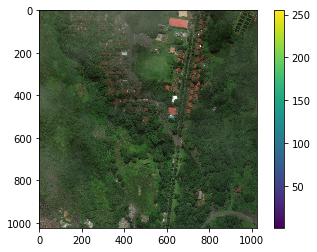

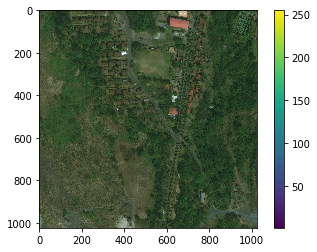

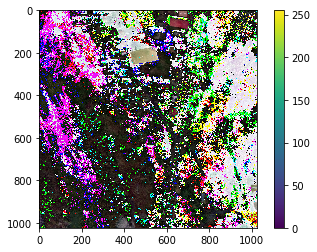

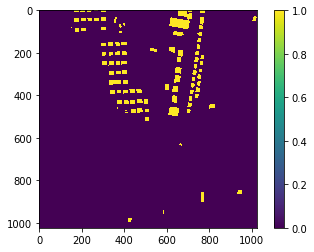

In [17]:
show_img(get_image(list_incident[3], 1))
show_img(get_image(list_incident[3], 0))
show_img(get_image(list_incident[3], 0) - get_image(list_incident[0], 1))
show_img(get_pixel_label(list_incident[3]))

In [11]:
def get_label(incident_id, post):
    '''
    inputs: incident_id (string) : nom de la photo (exemple : hurricane-florence_00000044)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: dictionary:
                - "features" (properties of the image):
                    list of info for each building as dictionary:
                        - "uid" (string) id of the building
                        - "wkt" (list): list of the integer coordinates of the box for the building
                        - "damage" (int): 0 to 3 or -1, refer to the classification (only for post data)
                - "metadata": dictionary with
                    - "gsd" (ground sample distance)
                    - "off_nadir_angle"
                    - "sun_azimuth"
                    - "sun_elevation"
                    - "target_azimuth"
                    - "disaster"
                    - "disaster_type"
                    - "width"
                    - "height"
    '''
    postfixe = "_post_disaster.json" if post else "_pre_disaster.json"
    with open(PATH_TO_DATASET + "labels\\" + incident_id + postfixe) as json_file:
        data = json.load(json_file)
    
    data["features"] = data["features"]["xy"]
    for b in range(len(data["features"])):
        building = data["features"][b]
        building_filtered = {"uid": building["properties"]["uid"]}
        polygon = wkt.loads(building['wkt'])
        polygon = np.array(list(zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])))
        building_filtered["wkt"] = polygon
        if post:
            damage = {'destroyed':4, 'major-damage':3, 'minor-damage':2, 'no-damage':1, \
                      'un-classified':0}[building['properties']["subtype"]]
            building_filtered["damage"] = damage
        data["features"][b] = building_filtered
    
    # Filter available fields for the metadata
    metadataFields = ["gsd", "off_nadir_angle", "sun_azimuth", "sun_elevation", "target_azimuth", \
                     "disaster", "disaster_type", "width", "height"]
#     data["metadata"] = {k:v for k,v in data["metadata"].items() if k in metadataFields}
    
    return data

In [14]:
def extract_images1(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: list of pairs (sub images, damage) (length 2**20 / sizeCut^2, each sub image has size sizeCut*sizeCut)
    '''
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
    buildings_labels = []
    for b in labels["features"]:
        if post:
            buildings_labels.append((b["wkt"], b["damage"]))
        else:
            buildings_labels.append((b["wkt"], 1))    
    
    # Detection of buildings
    number_division = 2**10//SIZE_BUILDING_SEARCH 
    buildings_array = np.zeros((number_division, number_division))
    for coordinates,l in buildings_labels :
        for x,y in coordinates :
            i,j = int(x // SIZE_BUILDING_SEARCH), int(y // SIZE_BUILDING_SEARCH)
            i,j = max(i,0), max(j,0)
            i,j = min(i,number_division-1),min(j,number_division-1)
            buildings_array[i,j] = 1
            
            
    # Extract subimages
    subImages = []
    fact = SIZE_CUTS//SIZE_BUILDING_SEARCH
    for i in range(2**10 // SIZE_CUTS):
        for j in range(2**10 // SIZE_CUTS):
            subImage = (img[i*SIZE_CUTS:(i+1)*SIZE_CUTS, j*SIZE_CUTS:(j+1)*SIZE_CUTS], buildings_array[i*fact:(i+1)*fact, j*fact:(j+1)*fact])
#             show_img(img[i*SIZE_CUTS:(i+1)*SIZE_CUTS, j*SIZE_CUTS:(j+1)*SIZE_CUTS])
#             print("building array: \n", buildings_array[i*fact:(i+1)*fact, j*fact:(j+1)*fact])
            subImages.append(subImage)
            
            
    return subImages

In [15]:
def get_image_colle(Incident_id):
    pre = get_image(Incident_id,False)
    post = get_image(Incident_id,True)
    return np.concatenate((pre,post),axis = 2)/255

In [16]:
def get_pixel_label(incident_id):
    '''
    return a 1024 * 1024 * 1 ndarray
    '''
    
    new_label = np.zeros((1024, 1024))
    with open(PATH_TO_DATASET + "labels\\" + incident_id + "_post_disaster.json") as json_file:
        data = json.load(json_file)
        data["features"] = data["features"]["xy"]
        for b in range(len(data["features"])):
            building = data["features"][b]
            damage = 'un-classified'
            if "subtype" in building["properties"]:
                damage = building["properties"]["subtype"]
            damage_dict = {'destroyed': 4, 'major-damage': 3, 'minor-damage': 2, 'no-damage': 1, 'un-classified': 0}
            damage = damage_dict[damage]
#             print(damage)
            polygon = wkt.loads(building['wkt'])
            polygon = np.array(list(zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])))
            b = polygon,
            zone = [(floor(b[0][:, 0].min()), floor(b[0][:, 1].min())),
                    (ceil(b[0][:, 0].max()), ceil(b[0][:, 1].max()))]
            for i in range(zone[1][0] - zone[0][0] ):
                for j in range(zone[1][1] - zone[0][1] ):
                    if geometry.Polygon(b[0]).contains(all_points_grid[zone[0][0] + i][zone[0][1] + j]):
                        new_label[zone[0][0]+i, zone[0][1]+j] = damage
    return new_label

In [ ]:
getpi

In [13]:
SIZE_SKIP = 4;
SIZE_CUT = 128

In [14]:

def extract_images_pixel(incident_id):
    '''
    inputs: img (Image object or np.array)
    output: the subimages and a matrix of pixel label of same size;
    '''
    img = get_image_colle(incident_id)
    labels = get_pixel_label(incident_id)
    subImages = [];
    for i in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
        for j in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
            subImages.append((img[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS], 
                              labels[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS]))
    return subImages


In [15]:

def extract_images_max(incident_id):
    '''
    inputs: img (Image object or np.array)
    output: the subimages and a matrix of pixel label of same size;
    '''
    img = get_image_colle(incident_id)
    labels = get_pixel_label(incident_id)
    subImages = [];
    for i in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
        for j in range((1024-SIZE_CUT)//(SIZE_SKIP)+1):
            subImages.append((img[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS], 
                              np.max(labels[i*SIZE_SKIP:i*SIZE_SKIP+SIZE_CUTS, j*SIZE_SKIP:j*SIZE_SKIP+SIZE_CUTS])))
    return subImages

# Model Images(Matrice) à Scalaire

In [63]:
class Dataset_generator_max(Sequence) :
    def __init__(self, ids, batch_size=16):
        self.ids = ids
        self.im_index = 0
        self.batch_size = batch_size
        self.sub_image_queue = queue.Queue()
        self.steps_per_epoch = (((1024-SIZE_CUT)//(SIZE_SKIP)+1)**2 * len(ids) ) // batch_size
    def get_next_images(self):
        
        for data in extract_images_max(self.ids[self.im_index]):
            self.sub_image_queue.put(data)
        self.im_index = (self.im_index + 1) % len(self.ids)
    
    def __len__(self) :
        return self.steps_per_epoch
    def get_item(self):
        x = []
        y = []
        if self.sub_image_queue.empty():
            self.get_next_images()
        image,label = self.sub_image_queue.get()
        return image, label

In [64]:
train_gen = Dataset_generator_max(list_incident[:])

In [65]:
train_set = []
train_label = []
TRAINING_SIZE = 2**13
for i in range(TRAINING_SIZE):
    t = train_gen.get_item()
    train_set.append(t[0]);
    train_label.append(t[1]);

In [66]:
train_set = np.array(train_set)
train_set = train_set.reshape(len(train_set), SIZE_CUT, SIZE_CUT, 6);
train_label = np.array(train_label)
train_label = train_label.reshape(len(train_label))

In [67]:
# Keras Model Building
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(SIZE_CUT, SIZE_CUT, 6)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 64)      3520      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
__________

In [69]:
train_set.shape

(8192, 128, 128, 6)

In [70]:
train_label.shape

(8192,)

In [71]:
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model.fit(train_set, train_label, shuffle = True, validation_split = 0.2 ,batch_size= 64, epochs=8)

Train on 6553 samples, validate on 1639 samples
Epoch 1/8
6553/6553 [==============================] - 17s 3ms/sample - loss: 0.1825 - acc: 0.9361 - val_loss: 0.0612 - val_acc: 0.9793
Epoch 2/8
4864/6553 [=====================>........] - ETA: 3s - loss: 0.0474 - acc: 0.9809

KeyboardInterrupt: 

# Model de Image à Matrice

In [20]:
class Dataset_generator_pixel(Sequence) :
    def __init__(self, ids, batch_size=16):
        self.ids = ids
        self.im_index = 0
        self.batch_size = batch_size
        self.sub_image_queue = queue.Queue()
        self.steps_per_epoch = (((1024-SIZE_CUT)//(SIZE_SKIP)+1)**2 * len(ids) ) // batch_size
    def get_next_images(self):
        
        for data in extract_images_pixel(self.ids[self.im_index]):
            self.sub_image_queue.put(data)
        self.im_index = (self.im_index + 1) % len(self.ids)
    
    def __len__(self) :
        return self.steps_per_epoch
    def get_item(self):
        x = []
        y = []
        if self.sub_image_queue.empty():
            self.get_next_images()
        image,label = self.sub_image_queue.get()
        return image, label

In [21]:
train_gen = Dataset_generator_pixel(list_incident[:])

In [22]:
train_set = []
train_label = []
TRAINING_SIZE = 2**13
for i in range(TRAINING_SIZE):
    t = train_gen.get_item()
    train_set.append(t[0]);
    train_label.append(t[1]);

In [23]:
train_set = np.array(train_set)
train_set = train_set.reshape(len(train_set), SIZE_CUT, SIZE_CUT, 6);
train_label = np.array(train_label)
train_label = train_label.reshape(len(train_label), SIZE_CUT, SIZE_CUT, 1)

In [24]:
# Keras Model Building

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(SIZE_CUT, SIZE_CUT, 6)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2DTranspose(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2DTranspose(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2DTranspose(64, (3, 3), activation='relu'))
model.add(keras.layers.Conv2DTranspose(filters = 5, kernel_size = (3,3), activation = "sigmoid"))


Instructions for updating:
Colocations handled automatically by placer.


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      3520      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 64)      36928     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 122, 122, 64)      36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 124, 124, 64)      36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 126, 126, 64)      36928     
__________

In [26]:
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer= adam,
              loss='MSE',
              metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


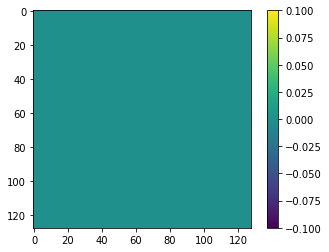

In [27]:
model.fit(train_set, train_label, shuffle = True, validation_split = 0.2 ,batch_size= 64, epochs=5)

Train on 6553 samples, validate on 1639 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
6553/6553 [==============================] - 70s 11ms/sample - loss: 0.0252 - acc: 0.9078 - val_loss: 0.0589 - val_acc: 0.9993
Epoch 2/5
6553/6553 [==============================] - 61s 9ms/sample - loss: 0.0149 - acc: 0.9994 - val_loss: 0.0589 - val_acc: 0.9995
Epoch 3/5
2752/6553 [===========>..................] - ETA: 31s - loss: 0.0134 - acc: 0.9995

KeyboardInterrupt: 

# Notre Résultat

In [35]:
model.predict(np.array([train_set[0]])).shape

(1, 128, 128, 5)

# Model Difference et Soleil

In [16]:
def label_image(incident_id, post):
    '''
    inputs: img (Image object or np.array)
            post (booléen): True pour l'image après le désastre, False pour l'image avant
    output: np.array with size 1024*1024*5, the third dimension giving the classes
    '''
#     print("Getting image: ");
#     print("---------------------------------------------------------------------------------------------------------------------")
    img = get_image(incident_id, post)
    labels = get_label(incident_id, post)
#     print("images: ", img);
#     print("Getting labels: ");
#     print("---------------------------------------------------------------------------------------------------------------------")
#     print()
    buildings_labels = []
    for b in labels["features"]:
        if post:
#             print("wkt: ", b["wkt"], " damage: ", b["damage"])
            buildings_labels.append((b["wkt"], b["damage"]))
        else:
            buildings_labels.append((b["wkt"], 1)) 
    labeled_img = np.zeros((1024,1024,5))
    labeled_img[:,:,0] += 1
    for b in buildings_labels:
        zone = [(floor(b[0][:,0].min()), floor(b[0][:,1].min())), (ceil(b[0][:,0].max()), ceil(b[0][:,1].max()))]
        polygon = geometry.Polygon(b[0])
        for i in range(zone[1][0]-zone[0][0]):
            for j in range(zone[1][1]-zone[0][1]):
                if polygon.contains(all_points_grid[zone[0][0]+i][zone[0][1]+j]):
                    labeled_img[zone[0][0]+i, zone[0][1]+j, 0] = 0
                    labeled_img[zone[0][0]+i, zone[0][1]+j, b[1]] = 1
    
    return labeled_img


In [17]:
def difference(incident_id):
    
    labels_post=get_label(incident_id,True)
    labels_pre=get_label(incident_id,False)
    
    imgpost=get_image(incident_id,True)
    labeled_post=label_image(incident_id,True)
    
    imgpre=get_image(incident_id,False)
    
    lpost=labels_post["features"] #liste de dict de buildings
    lpre=labels_pre["features"]
    l=min(len(lpost),len(lpre)) 
    
    labels=[]
    
    diff=np.zeros((0,3))
    
    inputs=[]
    
    for k in range(l):
        b1=lpost[k]
        zone1 = [(floor(b1["wkt"][:,0].min()), floor(b1["wkt"][:,1].min())), (ceil(b1["wkt"][:,0].max()), ceil(b1["wkt"][:,1].max()))]
        b2=lpre[k]
        zone2 = [(floor(b2["wkt"][:,0].min()), floor(b2["wkt"][:,1].min())), (ceil(b2["wkt"][:,0].max()), ceil(b2["wkt"][:,1].max()))]
        if b1["uid"]==b2["uid"]:
            im1=np.zeros((zone1[1][0]-zone1[0][0],zone1[1][1]-zone1[0][1],3))
            im2=np.zeros((zone2[1][0]-zone2[0][0],zone2[1][1]-zone2[0][1],3))
            polygon1 = geometry.Polygon(b1["wkt"])
            for i in range(zone1[1][0]-zone1[0][0]):
                for j in range(zone1[1][1]-zone1[0][1]):
                    if (zone1[0][0]+i)<len(all_points_grid) and (zone1[0][1]+j)<len(all_points_grid[0]):
                        if polygon1.contains(all_points_grid[zone1[0][0]+i][zone1[0][1]+j]):
                            im1[i,j,:]=imgpost[zone1[0][0]+i, zone1[0][1]+j, :]
                        #im1=np.append(im1,[imgpost[zone1[0][0]+i, zone1[0][1]+j, :]],axis=0)
                        
                        
            polygon2 = geometry.Polygon(b2["wkt"])        #labels=np.append(labels,np.where(labeled_post[zone1[0][0]+i, zone1[0][1]+j, :]==1),axis=0)
            for i in range(zone2[1][0]-zone2[0][0]):
                for j in range(zone2[1][1]-zone2[0][1]):
                    if polygon2.contains(all_points_grid[zone2[0][0]+i][zone2[0][1]+j]):
                        if (zone2[0][0]+i)<len(all_points_grid) and (zone2[0][1]+j)<len(all_points_grid[0]):
                            im2[i,j,:]=imgpre[zone2[0][0]+i, zone2[0][1]+j, :]
                        #im2=np.append(im2,[imgpre[zone2[0][0]+i, zone2[0][1]+j, :]],axis=0)
            r2=np.mean(im2[:,:,0])
            g2=np.mean(im2[:,:,1])
            bleu2=np.mean(im2[:,:,2])
            r1=np.mean(im1[:,:,0])
            g1=np.mean(im1[:,:,1])
            bleu1=np.mean(im1[:,:,2])
            labels+=[b1["damage"]]
            sun1=labels_post["metadata"]["sun_azimuth"]
            sun2=labels_pre["metadata"]["sun_azimuth"]
            inputs+=[[r1,g1,bleu1,sun1,r2,g2,bleu2,sun2]]
    #inputs+=
    
        
    return inputs,labels

def get_trainset (size = 32):
    
    inputs=[]
    labels=[]
    
    incidents_list = get_incident_list()
    incidents_list = np.random.choice(incidents_list, size)
    print(len(incidents_list))
    for inc in incidents_list:
#         size -= 1;
        print("incident: ", inc)
        inputs+=difference(inc)[0]
        labels+=difference(inc)[1]
#         if (size < 0):
#             return inputs,labels
    return inputs, labels

In [18]:
train_set, train_label = get_trainset(64)

64
incident:  midwest-flooding_00000020
incident:  hurricane-florence_00000540
incident:  hurricane-florence_00000302
incident:  palu-tsunami_00000164
incident:  hurricane-matthew_00000271
incident:  hurricane-harvey_00000119
incident:  socal-fire_00000992
incident:  santa-rosa-wildfire_00000253
incident:  santa-rosa-wildfire_00000304
incident:  hurricane-michael_00000293
incident:  midwest-flooding_00000002
incident:  midwest-flooding_00000085
incident:  midwest-flooding_00000398
incident:  hurricane-florence_00000473
incident:  socal-fire_00000166
incident:  hurricane-michael_00000142
incident:  hurricane-florence_00000190
incident:  santa-rosa-wildfire_00000041
incident:  midwest-flooding_00000357
incident:  santa-rosa-wildfire_00000210
incident:  midwest-flooding_00000196
incident:  hurricane-matthew_00000197
incident:  santa-rosa-wildfire_00000283
incident:  socal-fire_00000592
incident:  socal-fire_00000277
incident:  midwest-flooding_00000426
incident:  guatemala-volcano_0000002

KeyboardInterrupt: 

In [19]:
train_set

NameError: name 'train_set' is not defined

In [216]:
train_set = np.array(train_set)
#train_set = train_set.reshape(len(train_set), 8);
train_label = np.array(train_label)
#train_label = train_label.reshape(len(train_label), 1)

In [217]:
train_set.shape

(2059, 8)

In [218]:
train_label.shape

(2059,)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[8]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation = "softmax")
  ])

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=["accuracy"])

In [221]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_58 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 325       
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [222]:
model.fit(
  train_set, train_label, epochs = 10,validation_split = 0.2)

Train on 1647 samples, validate on 412 samples
Epoch 1/10
1647/1647 [==============================] - 1s 536us/sample - loss: 13.8243 - acc: 0.1396 - val_loss: 15.8688 - val_acc: 0.0146
Epoch 2/10
1647/1647 [==============================] - 0s 159us/sample - loss: 12.2584 - acc: 0.2386 - val_loss: 15.8793 - val_acc: 0.0146
Epoch 3/10
1647/1647 [==============================] - 0s 155us/sample - loss: 12.2846 - acc: 0.2368 - val_loss: 15.8083 - val_acc: 0.0146
Epoch 4/10
1647/1647 [==============================] - 0s 193us/sample - loss: 12.2539 - acc: 0.2392 - val_loss: 15.8834 - val_acc: 0.0146
Epoch 5/10
1647/1647 [==============================] - 0s 163us/sample - loss: 12.2525 - acc: 0.2398 - val_loss: 15.8834 - val_acc: 0.0146
Epoch 6/10
1647/1647 [==============================] - 0s 161us/sample - loss: 12.2525 - acc: 0.2398 - val_loss: 15.8834 - val_acc: 0.0146
Epoch 7/10
1647/1647 [==============================] - 0s 159us/sample - loss: 12.2525 - acc: 0.2398 - val_loss: